## Automatic Learning of Summary Statistics for Approximate Bayesian Computation Using Deep Learning



Samuel Wiqvist, Ph.D. Student, Lund University.

Work with: Pierre-Alexandre Mattei (ITU), Umberto Picchini (GU/Chalmers), and Jes Frellsen (ITU). 

In [52]:
# load packages and set up
using PyPlot
using Distributions
using Printf
using Random 
using KernelDensity

# data model
Random.seed!(12)
α = 2; β = 2
m = 4; n = 5; p = 0.7
y_obs = rand(Binomial(m,p),n) # generate data

# analytical posterior
posterior = Beta(α + sum(y_obs), β + m*n - sum(y_obs));

# plot function
function plot_abc_inference_results(abc_posterior_samples)
    
    kde_approx_posterior = kde(abc_posterior_samples)

    # plot results
    PyPlot.figure(figsize=(7,4))
    PyPlot.plot(kde_approx_posterior.x,kde_approx_posterior.density, "b")
    PyPlot.plot(0:0.01:1,pdf.(posterior, 0:0.01:1), "r")
    PyPlot.plot(0:0.01:1, pdf.(prior, 0:0.01:1), "g")
    PyPlot.plot((p, p), (0, maximum(pdf.(posterior, 0:0.01:1))), "k")
    PyPlot.xlabel("p")
    PyPlot.ylabel("Density")
    PyPlot.legend(["ABC posterior"; "Analytical posterior"; "Prior"; "True value"])

end 

plot_abc_inference_results (generic function with 1 method)

#### What we will talk about today

* Introduction to ABC;


* How we can leverage deep learning methods to learn the summary statistics for ABC; 
    * Present the main results from the paper:  *Partially Exchangeable Networks and Architectures for Learning Summary Statistics in Approximate Bayesian Computation* (accepted for ICML 2019);


* We will have a practical focus and run ABC for a simple model (the Beta-Binomial model).   

#### Approxiamte Bayesian Computation: Simulation based inference 

* ABC in a nut-shell: Simulations-based inference method where we generate parameter proposals $\theta^\star$ and accept $\theta^\star$ if the generated data $y^{\star}\sim p(y|\theta^\star)$ is *similar* to our observed data $y^{\text{obs}}$;

* ABC only requires that we can simulate data from our model $p(y|\theta)$, thus ABC is very generic, and can be applied for models where the likelihood is intractable.   

* *Curse-of-dimensionality*: Instead of comparing the data sets we compare a set of summary statistics $s =S(y)$. The main focus of our work is how we  *automatically* can learn the summary statistics.

#### Approxiamte Bayesian Computation: Rejection sampling method 

* Generate $\tilde{N}$ independent proposals $\theta^i\sim p(\theta)$,  and corresponding data sets  $y^i\sim p(y|\theta^i)$ from the simulator $p(y|\theta)$;

* Compute the summary statistics $s^i = S(y^i)$ for each $i=1,\ldots,\tilde{N}$;

* Compute the distances $\Delta(s^{i}, s^{\text{obs}})$ for each $i=1,\ldots,\tilde{N}$. 

* Retain proposals $\theta^i$ corresponding to those $\Delta(s^{i}, s^{\text{obs}})$ such that  $\Delta(s^{i}, s^{\text{obs}}) \leq \epsilon$, for some  $\epsilon \geq 0$. 

#### Approxiamte Bayesian Computation: Approxiamte posterior 

* The joint distribution of accapted parameter-data paris $(\theta^{\star}, s^{\star})$ is 
$$p(\theta^{\star}, s^{\star}) = p(s^{\star}|\theta^{\star}) p(\theta^{\star}) I(\Delta(s^{\star},s^{\text{obs}}) \leq \epsilon),$$
where $s^{\text{obs}} = S(y^{\text{obs}})$, $I$ indicator kernel, $\Delta$ distance function, and $\epsilon$ the threshold.


* Now assume that $S(s^{\star}) = S(s^{\text{obs}}) \,\, \text{iff} \,\, y^{\star} = y^{\text{obs}}$ and let $\epsilon = 0$. Now marginlizing $s^{\star}$ yields the true posterior:
$$ p(\theta^{\star}) = \int p(s^{\star}|\theta^{\star}) p(\theta^{\star}) I(\Delta(s^{\star},s^{\text{obs}}) \leq \epsilon)   ds^{\star} = p(y |\theta^{\star}) p(\theta^{\star}) \propto  p(\theta^{\star}| y) .$$

* However, in (almost) all situations we sample from an approximate posterior: 

$$p^{\epsilon}_{\text{ABC}}(\theta^{\star} | s^{\text{obs}}) \propto \int p(s^{\star}|\theta^{\star}) p(\theta^{\star}) I(\Delta(s^{\star},s^{\text{obs}}) \leq \epsilon)   ds^{\star}.$$

HAVE TO LOOK AT THIS AGAIN

#### ABC rejection sampling for the Beta-Binomial model

In [2]:
# Define the model and the prior distribution.

Random.seed!(12) # fix random numbers 

# model parameters
m = 4; n = 5; p_true = 0.7

 # defined the data generating function
data_generator(p) = rand(Binomial(m,p),n) 

# generate data
y_obs = data_generator(p_true)

# prior 
α = 2; β = 2
prior = Beta(α,β);

#### ABC rejection sampling for the Beta-Binomial model 

In [3]:
# ABC rejection sampling algorithm 
function abc_rs(;N_proposals::Int, ϵ::Real)
    
    abc_posterior_samples = zeros(N_proposals)
    nbr_accapted_proposals = 0 
    
    for i in 1:N_proposals
    
        p_star = rand(prior) # sample parameter proposal from prior 
        y_star = data_generator(p_star) # generate data from the data model
        Δ = sum(abs.(sort(y_star)-sort(y_obs))) # compute ABC distance      
        
        if Δ <= ϵ # accapte proposal 
            nbr_accapted_proposals += 1 
            abc_posterior_samples[nbr_accapted_proposals] = p_star 
        end 
    end 
    
    return abc_posterior_samples[1:nbr_accapted_proposals]
end; 

#### ABC rejection sampling for the Beta-Binomial model 

In [4]:
# Run ABC rejection sampling
abc_posterior_samples = abc_rs(N_proposals = 10^6, ϵ  = 0);
@printf "Accaptance rate: %.2f %%" length(abc_posterior_samples)/10^6*100

Accaptance rate: 0.35 %

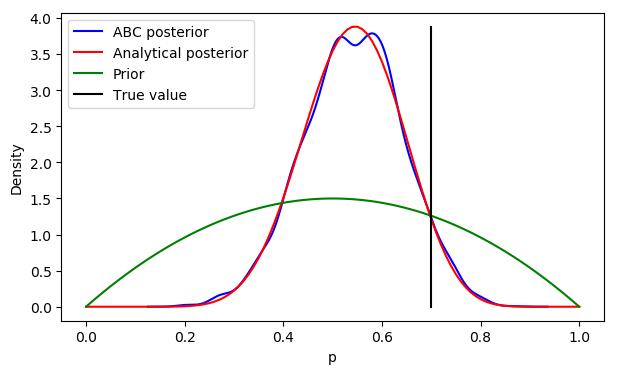

In [5]:
# plot posterior inference results 
plot_abc_inference_results(abc_posterior_samples);

#### ABC rejection sampling for the Beta-Binomial model (with summary statistics)

In [6]:
# defined the summary statistics 
S(y) = sum(y); # canonical statistics!

In [7]:
# ABC rejection sampling algorithm 
function abc_rs_summary_stats(;N_proposals::Int, ϵ::Real, S::Function)
    
    abc_posterior_samples = zeros(N_proposals)
    nbr_accapted_proposals = 0 
    
    for i in 1:N_proposals
    
        p_star = rand(prior) # sample parameter proposal from prior 
        y_star = data_generator(p_star) # generate data from the data model
        Δ =  abs(S(y_star)-S(y_obs)) # compute ABC distance      
        
        if Δ <= ϵ # accapte proposal 
            nbr_accapted_proposals += 1 
            abc_posterior_samples[nbr_accapted_proposals] = p_star 
        end 
    end 
    
    return abc_posterior_samples[1:nbr_accapted_proposals]
end; 

#### ABC rejection sampling for the Beta-Binomial model (with summary statistics)

In [99]:
# Run ABC rejection sampling
abc_posterior_samples = abc_rs_summary_stats(N_proposals = 10^6, ϵ  = 0.2, S=S);
@printf "Accaptance rate: %.2f %%" length(abc_posterior_samples)/10^6*100

Accaptance rate: 6.76 %

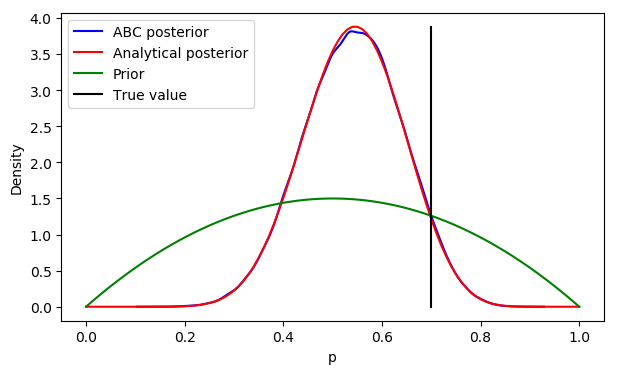

In [100]:
# plot posterior inference results 
plot_abc_inference_results(abc_posterior_samples);

#### How to select/learn summary statistics

* The summary statistics *should* be low-dimensional and informative for the parameters (in the ideal case sufficient).

* The problem of selecting informative summary statistics is the main challenge when applying ABC in practice;

* Usually, summary statistics are ad-hoc and "handpicked" out of subject-domain expertise. For example for dynamic models, summaries can be autocorrelations, cross-covariances, stationary mean. For iid data could be quantiles, mean and standard deviation etc.;

* Several methods to learn/select summary statistics have been developed (see (Prangle, 2015) for a review on these methods);

#### Learning summary statistics using linear regression

* An important paper is (Fearnhead, 2012) where they use linear regression to learn summary statistics, they also show that the posterior mean is the *best* (in terms of loss for the posterior mean) summary statistic; 

* The semi-automatic ABC (the method from (Fearnhead, 2012)):
    * We can sample a set of parameter-data pairs $(\theta^{i}, y^i)_{1 \leq i \leq N}$, by sampling $\theta^{i}$ from the prior, and then simulate corresponding data set $y^{i}$ from the simulator $p(y|\theta)$;    
    * Learn the posterior mean from the $N$ simulations,  using a linear regression model: $$\theta_j^i = E(\theta_j | y^i) + \xi_j^i = b_{0_j} + b_j h(y^i) + \xi_j^i.$$
    * After fitting the linear regression model $\tilde{b}_{0_j} + \tilde{b}_j h(y^{\star})$ is the j:th summary statistics for the proposed data set $y^{\star}$. 

#### Semi-automatic ABC for the Beta-Binomial model: Step 1: Generate data

In [1]:
# generate parameter-data pairs  
N = 1000
parameters = rand(prior, N)
data = zeros(N,5)
for i in 1:N; data[i,:] = data_generator(parameters[i]); end

UndefVarError: UndefVarError: prior not defined

#### Semi-automatic ABC for the Beta-Binomial model: Step 2: Fit linear regression model

In [ ]:
# Fit linear regression model 
β = (data'*data)\data'*parameters # ls estimation 

In [ ]:
# Define the new function to compute the summary statsitic 
S_semi_auto(y) = y'*β

#### Semi-automatic ABC for the Beta-Binomial model: Step 2: Run ABC algorithm

In [105]:
# Run ABC rejection sampling
abc_posterior_samples = abc_rs_summary_stats(N_proposals = 10^6, ϵ  = 0.025, S=S_semi_auto);
@printf "Accaptance rate: %.2f %%" length(abc_posterior_samples)/10^6*100

Accaptance rate: 6.89 %

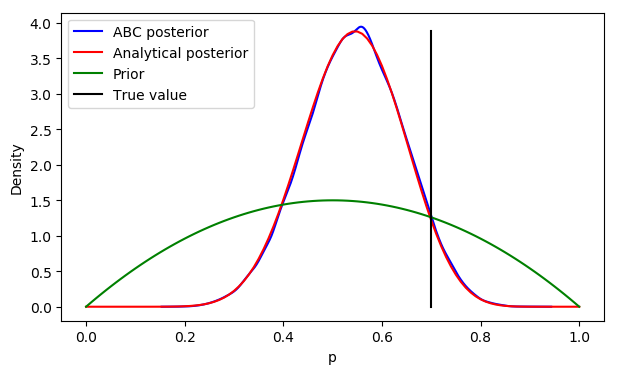

In [106]:
# plot posterior inference results 
plot_abc_inference_results(abc_posterior_samples);

#### Replacing linear regression with multilayer perceptron (MLP) network


* In (Jiang et.al 2017) they replace the linear regression model with a MLP network, thus they have following regression model: $$\theta^i = E(\theta|y^i) + \xi^i = f_{\beta}(y^i) + \xi^i.$$
    Where $f_{\beta}$ is the MLP parameterized by the weights $\beta$.


* Optimization problem: $$\min_{\beta}  \frac{1}{N} \sum_{i=1}^{N} \| f_{\beta}(y^i) - \theta^{i} \|^{2}_{2}.$$ Remember we are still trying to learn the posterior mean.


#### The partially exchangeable network (PEN) 

* Markovian data is *partial exchangabiliy* (which is a property that charaterize Markovian data the same way as $exchangability$ characterize "i.i.d" data); 

* Now, PEN is desigen such that it is invariante to the partial exchangabiliy property of Markovian data;

* We can write the PEN regression model as: $$\theta^i = E(\theta|y^i) + \xi^i = \rho_{\beta_{\rho}}\biggl(y^i_{1:d}, \sum_{l = 1}^{M-d}  \phi_{\beta_{\phi}}(y^i_{l:l+d})\biggr) + \xi^i. $$   

* The advangtae of PEN is that we now a archtecture that leverge that partial exchangabiliy property of Markovian data, and thus do not have to *learn* this property.

#### Results for the AR2 model

<img src="res_ar2_wasserstein.svg" width="1000" height="1000" align="center"/>


#### Results for the MA2 model with observation noise

<img src="res_ar2_wasserstein.svg" width="1000" height="1000" align="center"/>

TODO: include figure here


#### Conclusions 

* A praticla introduciton to ABC for a simple model (the Beta-Binomial model)

* We have studied how deep learning methods can be used to learn summary statistics ABC, and presented the entier workflow for a simple example;


* PEN is particular useful to use for timeseries data since the network leverage the Markovina structre of the data (for many more details and examples see (Wiqvist et.al 2019)).


#### The end

Homepage: http://www.maths.lu.se/staff/samuel-wiqvist/

Slides: https://github.com/SamuelWiqvist/bayesatlund2019presentation

Github: SamuelWiqvist

Twitter: samuel_wiqvist

#### References 

(Prangle, 2015) Bla bla bla

(Fearnhead, 2012 Bla bla bla 